In [ ]:
!pip install --upgrade keras==3.1.1

In [ ]:
!pip install --upgrade tensorflow==2.16.1

In [ ]:
!pip show keras

Name: keras
Version: 3.1.1
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: tensorflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import numpy as np

from keras.applications import ResNet50



from keras.layers import Input,Dense,Reshape,Conv2D,Conv2DTranspose
from keras.layers import BatchNormalization,LeakyReLU,Flatten
from keras.layers import Dropout,ZeroPadding2D,concatenate
from keras.layers import LeakyReLU, ReLU, GlobalAveragePooling2D

from keras.losses import BinaryCrossentropy, binary_crossentropy

from keras.models import Model, Sequential
from keras.optimizers import Adam


import random

import os

import tensorflow as tf


from tqdm import tqdm



In [1]:
import os

os.cpu_count()

24

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/python/Dataset/KaggleDataset2/grayzip')))

2001


In [ ]:
color_imgs_path = []
gray_imgs_path = []

In [ ]:


for i in tqdm(range(7)):
    path = os.path.join('/content/drive/MyDrive/python/restorasyon/Dataset/KaggleDataset2/colorzip',f'{i}.jpg')
    path2 = os.path.join('/content/drive/MyDrive/python/restorasyon/Dataset/KaggleDataset2/grayzip',f'{i}.jpg')
    if os.path.exists(path) and os.path.exists(path2):
        color_imgs_path.append(path)
        gray_imgs_path.append(path2)



100%|██████████| 7/7 [00:00<00:00, 1953.69it/s]


In [ ]:
gray_imgs_path[1]

'/content/drive/MyDrive/python/Dataset/KaggleDataset2/grayzip/1.jpg'

In [ ]:
color_img = []
gray_img = []

In [ ]:

SIZE = 256


for i in tqdm(color_imgs_path):
    img = cv2.imread(i)

    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(np.array(img.reshape(-1,256,256,3)))

for i in tqdm(gray_imgs_path):
    img = cv2.imread(i)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(np.array(img.reshape(-1,256,256,3)))

100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


In [ ]:
np.save('/content/drive/MyDrive/python/Dataset/KaggleDataset2/gray_img2.npy',gray_img)
np.save('/content/drive/MyDrive/python/Dataset/KaggleDataset2/color_img2.npy',color_img)

In [ ]:
color_img = list(np.load('/content/drive/MyDrive/python/Dataset/KaggleDataset2/color_img2.npy'))
gray_img = list(np.load('/content/drive/MyDrive/python/Dataset/KaggleDataset2/gray_img2.npy'))

In [ ]:
len(color_img)

4

In [ ]:
gray_img[0].shape

(1, 256, 256, 3)

In [ ]:
def load_data(data_dir):
    count = 0
    for filename in tqdm(os.listdir(data_dir)):
        image = cv2.imread(os.path.join(data_dir, filename))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)



        image = cv2.resize(image, dsize=size)
        gray = cv2.resize(gray, dsize=size)

        image = image.astype('float32') / 255.0
        gray = gray.astype('float32') / 255.0

        color_img.append(np.array(image.reshape(-1,256,256,3)))
        gray_img.append(np.array(gray.reshape(-1,256,256,3)))

        count += 1
        if count == 548:
            print("Durduruldu")
            break

    print("Dosyalar Yüklendi")

load_data("/content/drive/MyDrive/python/Dataset/humans")

 16%|█▌        | 547/3460 [02:13<11:51,  4.10it/s] 

Durduruldu
Dosyalar Yüklendi


In [ ]:
pred = generator(testimg, training=True)

InvalidArgumentError: Exception encountered when calling Concatenate.call().

[1m{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [1,128,256,64] vs. shape[1] = [1,128,255,64] [Op:ConcatV2] name: concat[0m

Arguments received by Concatenate.call():
  • inputs=['tf.Tensor(shape=(1, 128, 256, 64), dtype=float32)', 'tf.Tensor(shape=(1, 128, 255, 64), dtype=float32)']

In [ ]:
pred[0].shape

TensorShape([256, 512, 3])

In [ ]:
x,y = 256,510

testimg = np.resize(gray_img[0], (x,y, 3)).reshape(-1,x,y,3)
testimg.shape

(1, 256, 510, 3)

In [ ]:
color_img[1].shape

(1, 256, 256, 3)

# Build the model


In [ ]:
def downsample(filters, size, apply_batchnorm=True):

  model = Sequential()
  model.add(Conv2D(filters, size, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    model.add(BatchNormalization())

  model.add(LeakyReLU())
  return model

def upsample(filters, size, apply_dropout=False):

  model = Sequential()
  model.add(Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
  model.add(BatchNormalization())

  if apply_dropout:
      model.add(Dropout(0.5))

  model.add(ReLU())
  return model


In [ ]:
def Generator():
  inputs = Input(shape=[None,None,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)


  ]

  up_stack = [

    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)


  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(3, 4,strides=2,padding='same',kernel_initializer=initializer,activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concatenate([x, skip])

  x = last(x)

  return Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()
generator.summary()



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, None, None, 64) │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, None, None,     │        131,584 │ sequential[0][0]       │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, None, None,     │        525,312 │ sequential_1[0][0]     │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, None, None,     │      2,099,200 │ sequential_2[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_3[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_4[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_5[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_6[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_7[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, None,     │              0 │ sequential_8[0][0],    │
│                           │ 1024)                  │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, None, None,     │      8,390,656 │ concatenate[0][0]      │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, None, None,     │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │ 1024)                  │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, None, None,     │      8,390,656 │ concatenate_1[0][0]    │
│ (Sequential)         

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape=[256, 256, 3], name='input_image')
    tar = Input(shape=[256, 256, 3], name='target_image')

    x = concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down3 = downsample(512, 4)(down2)  # (bs, 32, 32, 256)
    # down3 = downsample(1024, 4)(down2)  # (bs, 32, 32, 256)

    # down3 çıkışını 3 kanala indiriyoruz
    conv3 = Conv2D(3, (1, 1), strides=1, padding='same',
                   kernel_initializer=initializer, use_bias=False)(down3)  # (bs, 32, 32, 3)

    # ResNet50 modelini ekleyelim
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # ResNet50 modelini dondur (önceden eğitilmiş ağırlıkları kullan)

    resnet_output = base_model(conv3)  # ResNet50 modeline giriş olarak conv3 katmanı verildi

    # Ekstra katmanlar ekleyelim
    flatten = Flatten()(resnet_output)
    dense = Dense(512, activation='relu', kernel_initializer=initializer)(flatten)
    dense = BatchNormalization()(dense)
    dense = LeakyReLU()(dense)

    last = Dense(1, activation='sigmoid', kernel_initializer=initializer)(dense)  # Çıkış katmanı

    return Model(inputs=[inp, tar], outputs=last)

In [ ]:
# generator = Generator()
discriminator = Discriminator()

discriminator.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256, 256, 6)    │              0 │ input_image[0][0],     │
│                           │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 128, 128, 64)   │          6,144 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 64, 64, 128)    │        131,584 │ sequential_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_11             │ (None, 32, 32, 512)    │      1,050,624 │ sequential_9[0][0]     │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 3)      │          1,536 │ sequential_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 1, 1, 2048)     │     23,587,712 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,049,088 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            513 │ leaky_re_lu_8[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,829,249 (98.53 MB)

 Trainable params: 2,239,233 (8.54 MB)

 Non-trainable params: 23,590,016 (89.99 MB)

In [ ]:
from keras.models import load_model

generator = load_model("/content/drive/MyDrive/python/humans/generator_model_epoch10.h5")
# Modeli yükle
# discriminator_model = load_model('/content/drive/MyDrive/python/humans/discriminator_model_epoch.h5')

# Modeli yeniden derle
generator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
os.listdir("/content/drive/MyDrive/python/restorasyon/main")

['generator_model_epoch10_t.h5',
 'discriminator_model_epoch10_t.h5',
 'generator_model_epoch35.h5',
 'generator_model_epoch30.h5',
 'generator_model_epoch25.h5',
 'generator_model_epoch20.h5',
 'discriminator_model_epoch20.h5',
 'discriminator_model_epoch30.h5',
 'discriminator_model_epoch35.h5',
 'discriminator_model_epoch25.h5',
 'generator_model_epoch45.h5',
 'discriminator_model_epoch45.h5',
 'generator_model_epoch50.h5',
 'discriminator_model_epoch50.h5']

# Check Loss


In [ ]:
genLoss=[]
discLoss=[]

In [ ]:
loss_object = BinaryCrossentropy(from_logits=True)
generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  genLoss.append(total_gen_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  discLoss.append(total_disc_loss)

  return total_disc_loss

In [ ]:


# without batch

# def train_step(input_image, target):
#   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#     gen_output = generator(input_image, training=True)

#     disc_real_output = discriminator([input_image, target], training=True)
#     disc_generated_output = discriminator([input_image, gen_output.numpy()], training=True)

#     gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#     disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#   generator_gradients = gen_tape.gradient(gen_total_loss,
#                                           generator.trainable_variables)
#   discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator.trainable_variables)

#   generator_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator.trainable_variables))
#   discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator.trainable_variables))

#   return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [ ]:
def train_step(input_image_batch, target_batch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0
        gen_gan_loss = 0
        gen_l1_loss = 0
        disc_loss = 0
        for input_image, target in zip(input_image_batch, target_batch):
            gen_output = generator(input_image, training=True)

            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output.numpy()], training=True)

            gen_total_loss_batch, gen_gan_loss_batch, gen_l1_loss_batch = generator_loss(disc_generated_output, gen_output, target)
            disc_loss_batch = discriminator_loss(disc_real_output, disc_generated_output)

            gen_total_loss += gen_total_loss_batch
            gen_gan_loss += gen_gan_loss_batch
            gen_l1_loss += gen_l1_loss_batch
            disc_loss += disc_loss_batch

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss


In [ ]:
from google.colab import output

output.enable_custom_widget_manager()

In [ ]:
EPOCHS = 100
batch_size = 32

def train():
    for epoch in range(EPOCHS ):
        combined = list(zip(gray_img, color_img))
        random.shuffle(combined)
        gray_img[:], color_img[:] = zip(*combined)

        print("Epoch:", epoch + 1)
        for i in tqdm(range(0, len(gray_img), batch_size)):
            batch_grayscale = gray_img[i:i+batch_size]
            batch_colored = color_img[i:i+batch_size]
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(batch_grayscale, batch_colored)
            # gen_total_loss, disc_loss = train_step(batch_grayscale, batch_colored)
        print("Epoch", epoch + 1, "completed.", "Generator loss:", gen_total_loss.numpy(), "Discriminator loss:", disc_loss.numpy())

        if epoch% 5 == 0 and epoch != 0:
            generator.save(f'/content/drive/MyDrive/python/humans/generator_model_epoch_nonedge{epoch+10}.h5')
            generator.save(f'/content/drive/MyDrive/python/humans/generator_noneedge{epoch+10}.hdf5')
            # discriminator.save(f'/content/drive/MyDrive/python/humans/discriminator_model_epoch{epoch}.h5')



    generator.save('/content/drive/MyDrive/python/humans/generator_noneedge.h5')
    generator.save('/content/drive/MyDrive/python/humans/generator_noneedge.hdf5')
    # discriminator.save('/content/drive/MyDrive/python/humans/discriminator.h5')


train()





Epoch: 1


  0%|          | 0/110 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:669: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  7%|▋         | 8/110 [04:32<57:55, 34.07s/it]


KeyboardInterrupt: 

# **Generate an image**

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)

    # BGR'den RGB'ye dönüşüm
    test_input_rgb = cv2.cvtColor((test_input[0]*255).astype('uint8'), cv2.COLOR_BGR2RGB)
    tar_rgb = cv2.cvtColor((tar[0]*255).astype('uint8'), cv2.COLOR_BGR2RGB)
    prediction_rgb = cv2.cvtColor((np.array(prediction[0])*255).astype('uint8'), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,15))

    display_list = [test_input_rgb, tar_rgb, prediction_rgb]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('on')
    plt.show()

    return prediction

import random
index = random.randint(0, len(gray_img))

combined = list(zip(gray_img, color_img))
random.shuffle(combined)
gray_img[:], color_img[:] = zip(*combined)


generate_images( generator, gray_img[1], color_img[1])


NameError: name 'gray_img' is not defined

# save model


#Test Model after saving


In [ ]:
from keras.models import load_model


loaded_model = load_model('/content/drive/MyDrive/python/restorasyon/main/generator_model_epoch50.h5')

loaded_model.compile()

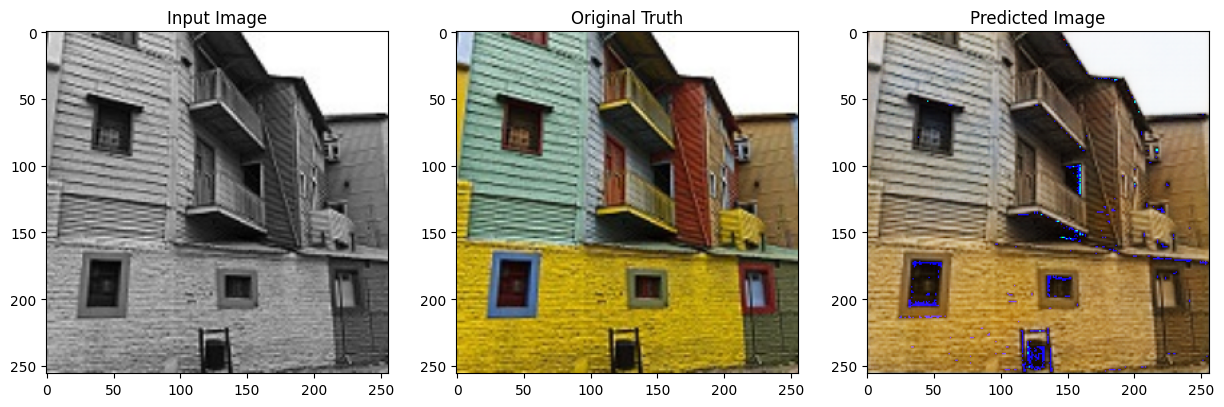

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)

    # BGR'den RGB'ye dönüşüm
    test_input_rgb = cv2.cvtColor((test_input[0]*255).astype('uint8'), cv2.COLOR_BGR2RGB)
    tar_rgb = cv2.cvtColor((tar[0]*255).astype('uint8'), cv2.COLOR_BGR2RGB)
    prediction_rgb = cv2.cvtColor((np.array(prediction[0])*255).astype('uint8'), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,15))

    display_list = [test_input_rgb, tar_rgb, prediction_rgb]
    title = ['Input Image', 'Original Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('on')
    plt.show()

    return prediction
import random
index = random.randint(0, len(gray_img))

pred = generate_images( loaded_model, gray_img[index], color_img[index])


In [ ]:
path = os.listdir("/content/drive/MyDrive/python/Test")

names = []
for i in path:
  if i.endswith(".jpg"):
    names.append(i)
imagess = []

for i in tqdm(path):
  if i.endswith(".jpg"):

    img = cv2.imread(os.path.join("/content/drive/MyDrive/python/Test", i))

    img = cv2.resize(img, (512, 512))
    img = img.astype('float32') / 255.0
    imagess.append(np.array(img.reshape(-1,512,512,3)))


100%|██████████| 19/19 [00:00<00:00, 42.96it/s]


In [ ]:
names

['test9.jpg',
 'test6.jpg',
 'test4.jpg',
 'test3.jpg',
 'orman_0.jpg',
 'test11.jpg',
 'test10.jpg',
 'test1.jpg',
 'cropped.jpg',
 'Ataturk1930s.jpg',
 'test5.jpg',
 'test2.jpg']

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input, training=True)

    # BGR'den RGB'ye dönüşüm
    test_input_rgb = cv2.cvtColor((test_input[0]*255).astype('uint8'), cv2.COLOR_BGR2RGB)

    prediction_rgb = cv2.cvtColor((np.array(prediction[0])*255).astype('uint8'), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,15))

    display_list = [test_input_rgb, prediction_rgb]
    title = ['Input Image','Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('on')
    plt.show()

    return prediction
import random
index = random.randint(0, len(imagess))
index =6
pred = generate_images( generator, imagess[index])


NameError: name 'imagess' is not defined

# Colorize Video


In [ ]:
def color_me(input_img, model):
  height, width, _ = input_img.shape
  input_img = cv2.resize(input_img, (256, 256))
  input_img = input_img.astype('float32') / 255.0

  input_img = input_img.reshape(-1, 256, 256, 3)
  prediction = model(input_img, training=True)

  cur = (np.array(prediction[0])*255).astype('uint8')


  cur = cv2.resize(cur, (width, height))

  return cur




In [ ]:
from IPython.display import clear_output


def colorize_video(input_video_path, output_video_name, model):

    cap = cv2.VideoCapture(input_video_path)

    # Video dosyasının genişliği ve yüksekliği alınır
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Video dosyası için bir VideoWriter nesnesi oluştur
    out = cv2.VideoWriter(f'{output_video_name}.mp4', cv2.VideoWriter_fourcc(*'xvid'), 30, (frame_width, frame_height))
    count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while True:
        ret, frame = cap.read()  # Bir sonraki kareyi oku
        if not ret:
            break  # Video bitti

        colored_frame = color_me(frame, model)  # Kareyi renklendir

        out.write(colored_frame)  # Renklendirilmiş kareyi video dosyasına yaz


        clear_output(wait=True)
        count += 1
        per:float = count / total_frames * 100
        print(f"Frame % {per}f ")


    # Temizlik
    cap.release()
    out.release()


In [ ]:
from datetime import datetime

now = datetime.now()
name = now.strftime("%d%m%Y_%H%M%S")

input_video = "/content/drive/MyDrive/python/restorasyon/test2.mp4"
output_video = f"/content/drive/MyDrive/python/{name}.mp4"

colorize_video(input_video, output_video, loaded_model)


Frame % 100.0f 


In [ ]:
import os.path

# Check if a file exists using its path.
file_path = "/content/drive/MyDrive/python/VID_48830720_044431_226.mp4"
if os.path.exists(file_path):
    print("The file exists.")
else:
    print("The file does not exist.")

The file exists.


In [ ]:
os.listdir("/content/drive/MyDrive/python")

['VID_48830720_044431_226.mp4',
 'Models',
 'Dataset',
 'cropped.jpg',
 'landspace.zip',
 'Models Generator 1',
 'Test',
 'testvideo.mp4',
 'models3',
 'renkli2.mp4']